# Etapa 2: Pré-Processamento de Dados

## Objetivos
Nesta etapa, limparemos e transformaremos os dados brutos analisados na Etapa 1, preparando-os para serem usados em modelos de Machine Learning. Aplicaremos técnicas para tratar problemas de qualidade e converter os dados em um formato numérico e padronizado.

**Lembre-se**: O foco aqui é transformar e limpar os dados, mantendo a qualidade e evitando data leakage.


In [47]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
import joblib
import os
import warnings

# Configuração para exibir gráficos inline no Jupyter Notebook
%matplotlib inline

# Configurações de visualização
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('seaborn-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Configuração para exibir todas as colunas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Configuração adicional para garantir que gráficos apareçam
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

print("Bibliotecas importadas com sucesso!")


Bibliotecas importadas com sucesso!


In [25]:
# Dicionário de tradução para nomes de colunas (usar em gráficos e tabelas)
TRADUCOES_COLUNAS = {
    'age': 'Idade',
    'study_hours_week': 'Horas de Estudo/Semana',
    'attendance_rate': 'Taxa de Frequência',
    'sleep_hours': 'Horas de Sono',
    'previous_scores': 'Notas Anteriores',
    'final_grade': 'Nota Final',
    'gender': 'Gênero',
    'parental_education': 'Educação dos Pais',
    'extracurricular': 'Atividades Extracurriculares',
    'tutoring': 'Tutoria',
    'internet_quality': 'Qualidade da Internet',
    'family_income': 'Renda Familiar',
    'health_status': 'Status de Saúde',
    'student_id': 'ID do Estudante'
}

# Carregar o dataset original
df = pd.read_csv('../../data/students_performance.csv')

print("Dataset carregado com sucesso!")
print(f"\nFormato original: {df.shape}")
print(f"Número de linhas: {df.shape[0]}")
print(f"Número de colunas: {df.shape[1]}")

# Criar uma cópia para trabalhar (preservar o original)
df_clean = df.copy()

print("\n" + "="*60)
print("Cópia do dataset criada para processamento")
print("="*60)


Dataset carregado com sucesso!

Formato original: (2510, 14)
Número de linhas: 2510
Número de colunas: 14

Cópia do dataset criada para processamento


## 1. Tratamento de Valores Faltantes

A maioria dos algoritmos de Machine Learning não consegue lidar com valores ausentes (NaN). Precisamos preenchê-los usando estratégias apropriadas.

### Estratégias:
- **Colunas Numéricas**: Usar mediana (mais robusta a outliers) ou média
- **Colunas Categóricas**: Usar a categoria mais frequente (moda)


In [50]:
# Verificar valores faltantes antes do tratamento
print("Valores Faltantes ANTES do tratamento:")
print("="*60)
missing_before = df_clean.isnull().sum()
missing_before_pct = (df_clean.isnull().sum() / len(df_clean)) * 100

missing_info = pd.DataFrame({
    'Valores Faltantes': missing_before,
    'Porcentagem (%)': missing_before_pct
})
missing_info = missing_info[missing_info['Valores Faltantes'] > 0].sort_values('Porcentagem (%)', ascending=False)
print(missing_info)


Valores Faltantes ANTES do tratamento:
Empty DataFrame
Columns: [Valores Faltantes, Porcentagem (%)]
Index: []


In [27]:
# Identificar variáveis numéricas e categóricas
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()

# Remover 'student_id' das categóricas (é um identificador, não uma feature)
if 'student_id' in categorical_cols:
    categorical_cols.remove('student_id')

print("Variáveis Numéricas:")
print(numeric_cols)
print(f"\nTotal: {len(numeric_cols)} variáveis numéricas")

print("\n" + "="*60)
print("\nVariáveis Categóricas (para encoding):")
print(categorical_cols)
print(f"\nTotal: {len(categorical_cols)} variáveis categóricas")


Variáveis Numéricas:
['age', 'study_hours_week', 'attendance_rate', 'sleep_hours', 'previous_scores', 'final_grade']

Total: 6 variáveis numéricas


Variáveis Categóricas (para encoding):
['gender', 'parental_education', 'extracurricular', 'tutoring', 'internet_quality', 'family_income', 'health_status']

Total: 7 variáveis categóricas


In [28]:
# 1.1 Tratamento de Valores Faltantes em Colunas Numéricas
# Usar mediana (mais robusta a outliers)

print("Tratando valores faltantes em colunas NUMÉRICAS...")
print("="*60)

numeric_cols_with_missing = [col for col in numeric_cols if df_clean[col].isnull().sum() > 0]

if len(numeric_cols_with_missing) > 0:
    # Usar SimpleImputer com estratégia 'median'
    imputer_numeric = SimpleImputer(strategy='median')
    df_clean[numeric_cols_with_missing] = imputer_numeric.fit_transform(df_clean[numeric_cols_with_missing])
    
    print(f"Valores faltantes preenchidos com MEDIANA nas colunas:")
    for col in numeric_cols_with_missing:
        print(f"  - {col}: {df[col].isnull().sum()} valores faltantes → {df_clean[col].isnull().sum()} valores faltantes")
else:
    print("Nenhuma coluna numérica com valores faltantes encontrada.")


Tratando valores faltantes em colunas NUMÉRICAS...
Valores faltantes preenchidos com MEDIANA nas colunas:
  - study_hours_week: 293 valores faltantes → 0 valores faltantes
  - attendance_rate: 232 valores faltantes → 0 valores faltantes
  - sleep_hours: 266 valores faltantes → 0 valores faltantes
  - previous_scores: 127 valores faltantes → 0 valores faltantes


In [29]:
# 1.2 Tratamento de Valores Faltantes em Colunas Categóricas
# Usar a categoria mais frequente (moda)

print("\nTratando valores faltantes em colunas CATEGÓRICAS...")
print("="*60)

categorical_cols_with_missing = [col for col in categorical_cols if df_clean[col].isnull().sum() > 0]

if len(categorical_cols_with_missing) > 0:
    # Usar SimpleImputer com estratégia 'most_frequent'
    imputer_categorical = SimpleImputer(strategy='most_frequent')
    df_clean[categorical_cols_with_missing] = imputer_categorical.fit_transform(df_clean[categorical_cols_with_missing])
    
    print(f"Valores faltantes preenchidos com MODA (categoria mais frequente) nas colunas:")
    for col in categorical_cols_with_missing:
        print(f"  - {col}: {df[col].isnull().sum()} valores faltantes → {df_clean[col].isnull().sum()} valores faltantes")
        if df[col].isnull().sum() > 0:
            mode_value = df[col].mode()[0] if len(df[col].mode()) > 0 else 'N/A'
            print(f"    Moda usada: '{mode_value}'")
else:
    print("Nenhuma coluna categórica com valores faltantes encontrada.")



Tratando valores faltantes em colunas CATEGÓRICAS...
Valores faltantes preenchidos com MODA (categoria mais frequente) nas colunas:
  - internet_quality: 155 valores faltantes → 0 valores faltantes
    Moda usada: 'Good'
  - family_income: 278 valores faltantes → 0 valores faltantes
    Moda usada: 'Medium'


In [30]:
# Verificar se ainda há valores faltantes
print("\n" + "="*60)
print("Verificação FINAL de valores faltantes:")
print("="*60)

missing_after = df_clean.isnull().sum()
missing_after_total = missing_after.sum()

if missing_after_total == 0:
    print("✅ SUCESSO! Todos os valores faltantes foram tratados.")
else:
    print(f"⚠️ ATENÇÃO: Ainda existem {missing_after_total} valores faltantes:")
    print(missing_after[missing_after > 0])



Verificação FINAL de valores faltantes:
✅ SUCESSO! Todos os valores faltantes foram tratados.


### Documentação: Decisões sobre Valores Faltantes

**Estratégias Aplicadas:**
- **Colunas Numéricas**: Mediana (robusta a outliers)
- **Colunas Categóricas**: Moda (categoria mais frequente)

**Justificativa:**
- A mediana é mais robusta que a média quando há outliers ou distribuições assimétricas
- A moda preserva a distribuição original das categorias
- Essas estratégias são simples e eficazes para este dataset

**Resultado:**
- [Preencher após execução: quantos valores foram imputados e em quais colunas]


## 2. Tratamento de Outliers

Valores extremos podem distorcer a escala das features e influenciar negativamente o treinamento de modelos, especialmente os lineares.

### Estratégias:
- **Capping (Limitar)**: Substituir outliers pelos limites do boxplot (Q1 - 1.5*IQR e Q3 + 1.5*IQR)
- **Remoção**: Apenas se tiver certeza de que são erros (usar com cuidado)
- **Manter**: Se são valores legítimos mas raros


In [52]:
# Identificar outliers usando o método IQR (da Etapa 1)
print("Análise de Outliers usando Método IQR:")
print("="*60)

outliers_info = {}

for col in numeric_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_lower = df_clean[df_clean[col] < lower_bound]
    outliers_upper = df_clean[df_clean[col] > upper_bound]
    outliers_count = len(outliers_lower) + len(outliers_upper)
    outliers_percentage = (outliers_count / len(df_clean)) * 100
    
    col_name_pt = TRADUCOES_COLUNAS.get(col, col)
    outliers_info[col_name_pt] = {
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Limite Inferior': lower_bound,
        'Limite Superior': upper_bound,
        'Número de Outliers': outliers_count,
        'Porcentagem (%)': outliers_percentage
    }

outliers_df = pd.DataFrame(outliers_info).T
print(outliers_df)


Análise de Outliers usando Método IQR:
                               Q1         Q3        IQR  Limite Inferior  \
Idade                   -0.693877   1.044712   1.738589        -3.301761   
Horas de Estudo/Semana  -0.682929   0.625989   1.308918        -2.646305   
Taxa de Frequência      -0.614954   0.659138   1.274092        -2.526092   
Horas de Sono           -0.627789   0.617399   1.245188        -2.495570   
Notas Anteriores        -0.636482   0.657287   1.293769        -2.577135   
Nota Final              86.982500  99.850000  12.867500        67.681250   

                        Limite Superior  Número de Outliers  Porcentagem (%)  
Idade                          3.652596                 0.0         0.000000  
Horas de Estudo/Semana         2.589365                 2.0         0.079681  
Taxa de Frequência             2.570277                 0.0         0.000000  
Horas de Sono                  2.485180                31.0         1.235060  
Notas Anteriores               2.

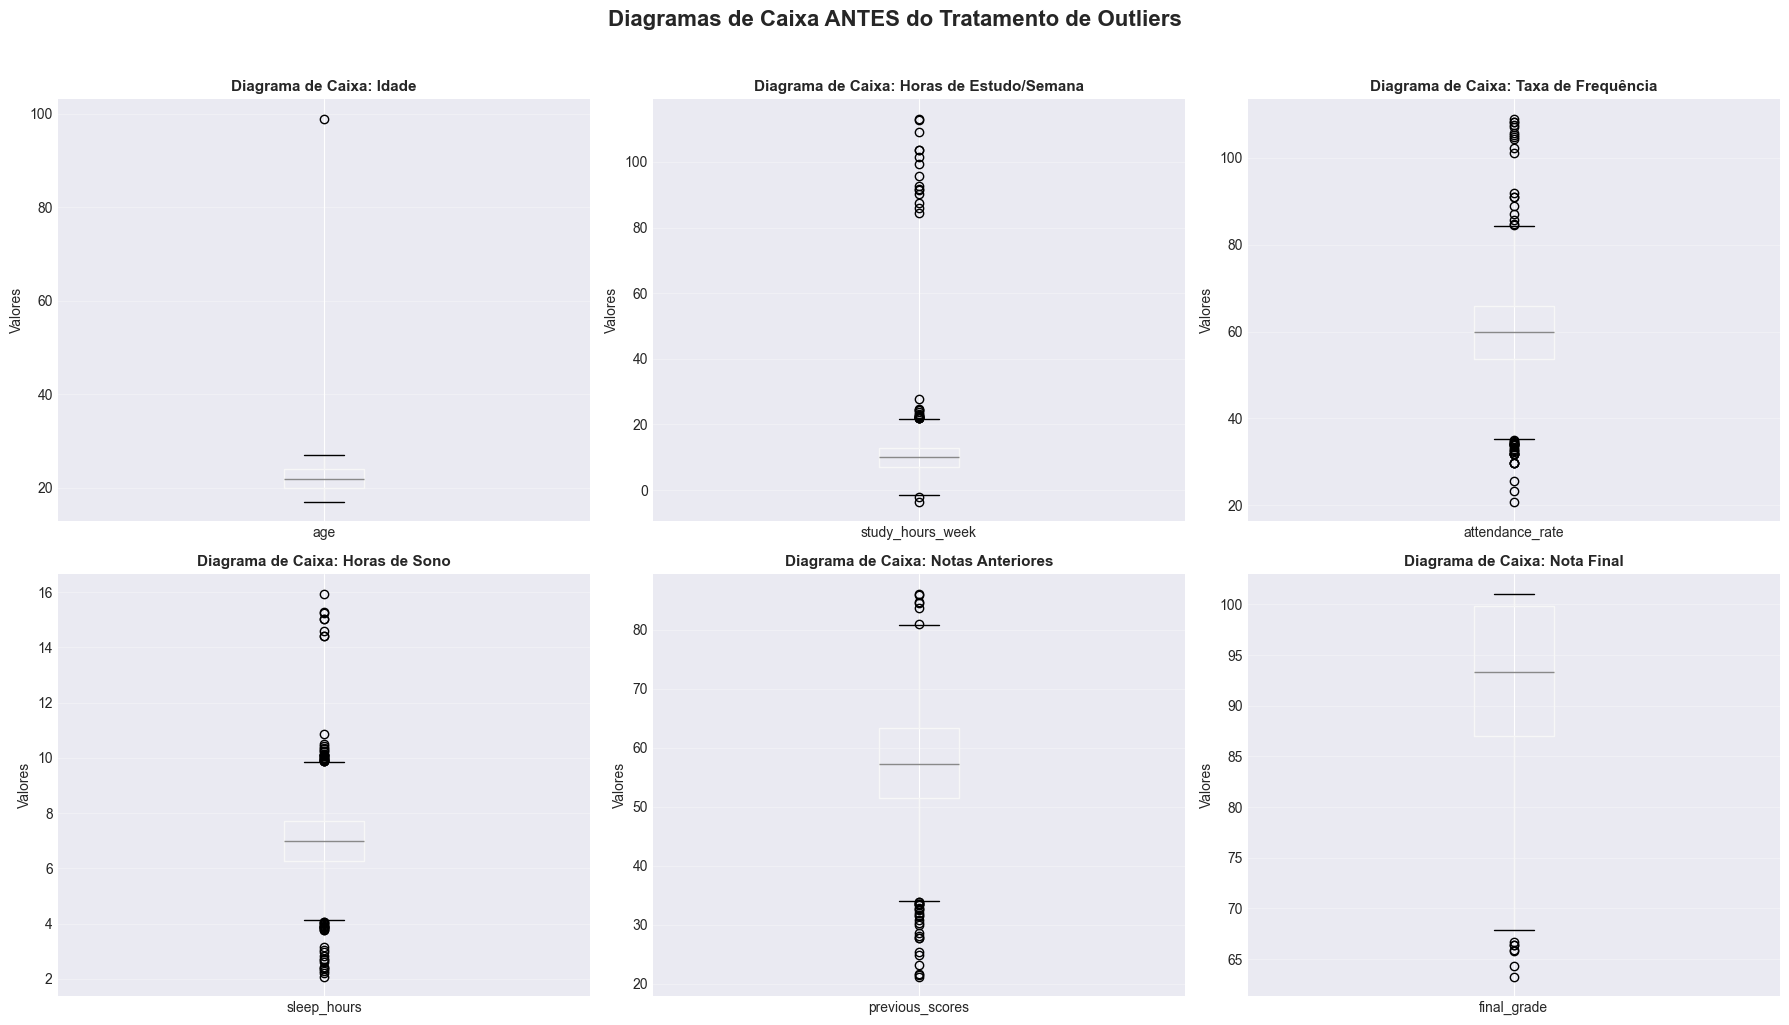

In [32]:
# Visualizar outliers antes do tratamento
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    if idx < len(axes):
        df_clean.boxplot(column=col, ax=axes[idx], vert=True)
        col_name_pt = TRADUCOES_COLUNAS.get(col, col)
        axes[idx].set_title(f'Diagrama de Caixa: {col_name_pt}', fontsize=11, fontweight='bold')
        axes[idx].set_ylabel('Valores', fontsize=10)
        axes[idx].grid(axis='y', alpha=0.3)

plt.suptitle('Diagramas de Caixa ANTES do Tratamento de Outliers', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


In [33]:
# 2.1 Aplicar Capping (Limitar) nos Outliers
# Estratégia: Substituir valores fora dos limites pelos próprios limites

print("Aplicando LIMITAÇÃO (capping) nos outliers...")
print("="*60)

# Colunas onde vamos aplicar capping (exceto a variável alvo)
cols_to_cap = [col for col in numeric_cols if col != 'final_grade']

for col in cols_to_cap:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Contar outliers antes
    outliers_before = len(df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)])
    
    # Aplicar capping
    df_clean[col] = df_clean[col].clip(lower=lower_bound, upper=upper_bound)
    
    # Contar outliers depois
    outliers_after = len(df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)])
    
    if outliers_before > 0:
        col_name_pt = TRADUCOES_COLUNAS.get(col, col)
        print(f"{col_name_pt} ({col}):")
        print(f"  Outliers antes: {outliers_before}")
        print(f"  Outliers depois: {outliers_after}")
        print(f"  Limites aplicados: [{lower_bound:.2f}, {upper_bound:.2f}]")

print("\n✅ Limitação aplicada com sucesso!")


Aplicando LIMITAÇÃO (capping) nos outliers...
Idade (age):
  Outliers antes: 1
  Outliers depois: 0
  Limites aplicados: [14.00, 30.00]
Horas de Estudo/Semana (study_hours_week):
  Outliers antes: 34
  Outliers depois: 0
  Limites aplicados: [-1.90, 21.77]
Taxa de Frequência (attendance_rate):
  Outliers antes: 47
  Outliers depois: 0
  Limites aplicados: [35.32, 84.38]
Horas de Sono (sleep_hours):
  Outliers antes: 58
  Outliers depois: 0
  Limites aplicados: [4.10, 9.86]
Notas Anteriores (previous_scores):
  Outliers antes: 31
  Outliers depois: 0
  Limites aplicados: [33.91, 80.88]

✅ Limitação aplicada com sucesso!


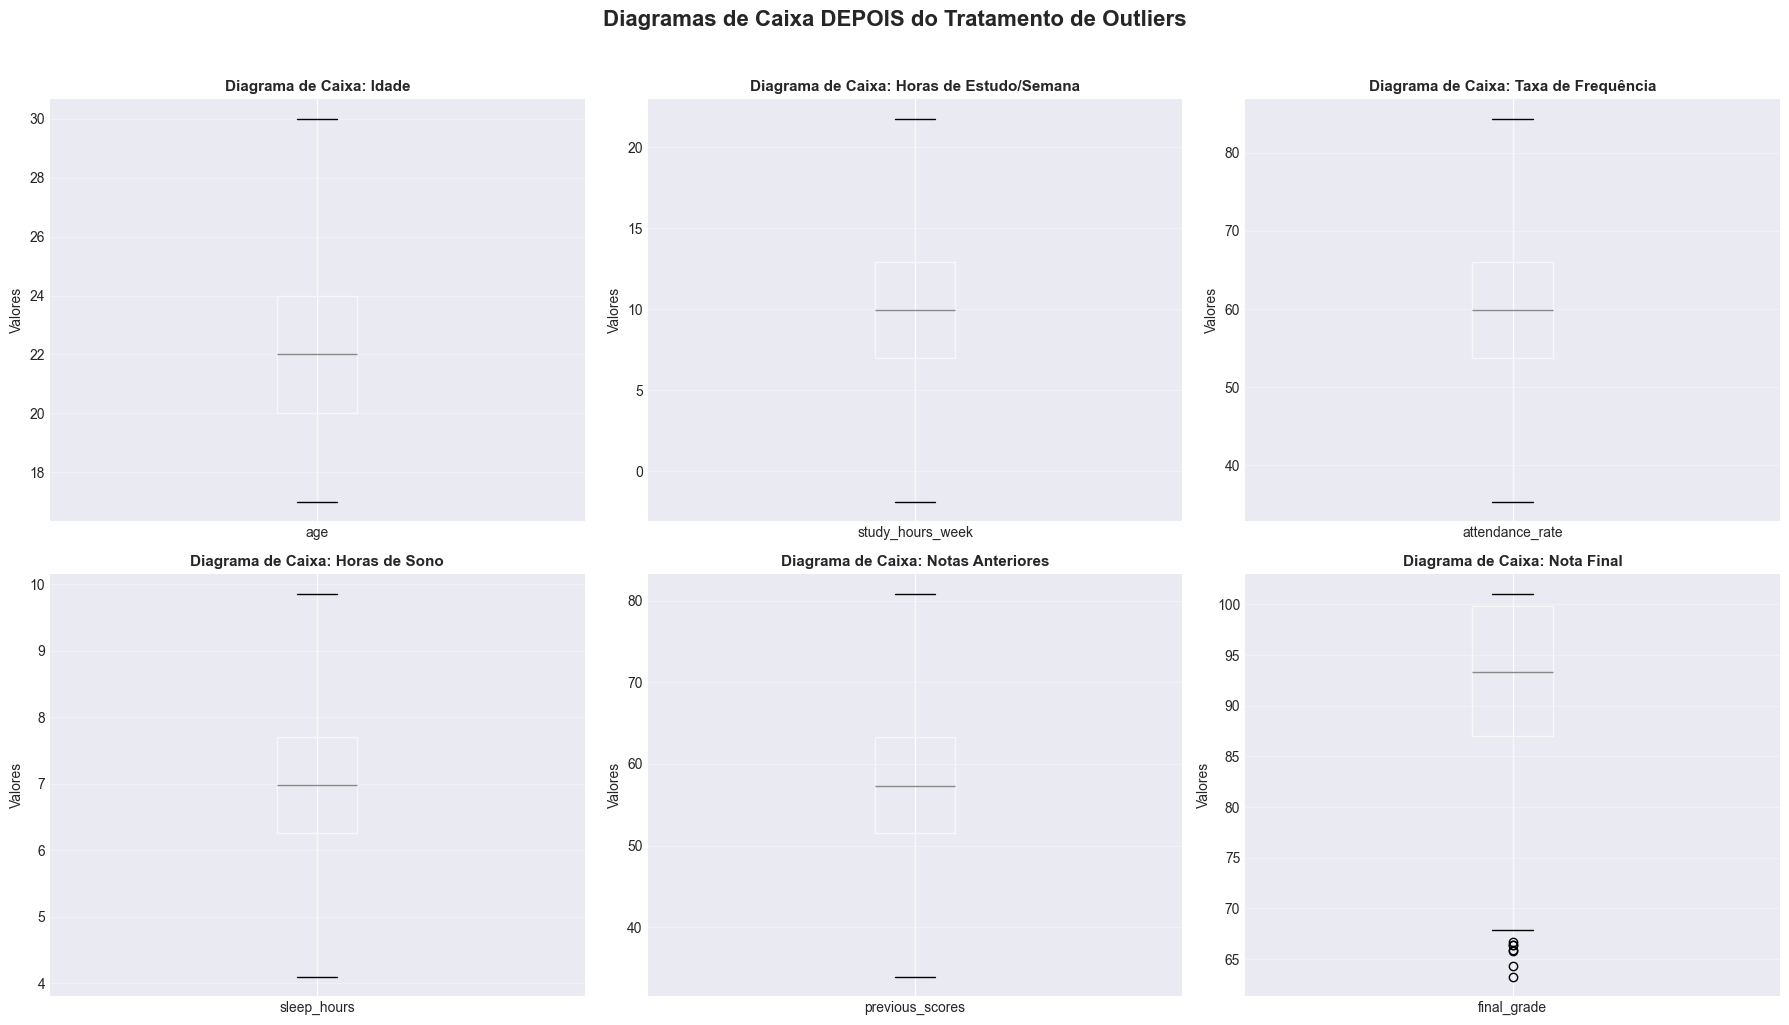

In [34]:
# Visualizar outliers depois do tratamento
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    if idx < len(axes):
        df_clean.boxplot(column=col, ax=axes[idx], vert=True)
        col_name_pt = TRADUCOES_COLUNAS.get(col, col)
        axes[idx].set_title(f'Diagrama de Caixa: {col_name_pt}', fontsize=11, fontweight='bold')
        axes[idx].set_ylabel('Valores', fontsize=10)
        axes[idx].grid(axis='y', alpha=0.3)

plt.suptitle('Diagramas de Caixa DEPOIS do Tratamento de Outliers', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


### Documentação: Decisões sobre Outliers

**Estratégia Aplicada:**
- **Capping (Limitação)**: Valores fora dos limites Q1-1.5*IQR e Q3+1.5*IQR foram limitados aos próprios limites

**Justificativa:**
- Preserva os dados (não remove registros)
- Reduz o impacto de valores extremos sem perder informação
- Mantém a distribuição dos dados dentro de limites razoáveis
- Não aplicamos na variável alvo (`final_grade`) para preservar sua distribuição original

**Colunas Tratadas:**
- [Listar colunas onde capping foi aplicado]

**Resultado:**
- [Preencher após execução: quantos outliers foram tratados]


## 3. Encoding de Variáveis Categóricas

Modelos de ML trabalham com números, não com texto. Precisamos converter colunas categóricas em representações numéricas.

### Estratégias:
- **One-Hot Encoding**: Para variáveis nominais (sem ordem natural)
- **Ordinal Encoding**: Para variáveis ordinais (com ordem clara)


In [35]:
# Verificar variáveis categóricas antes do encoding
print("Variáveis Categóricas antes do Encoding:")
print("="*60)

for col in categorical_cols:
    print(f"\n{col}:")
    print(f"  Valores únicos: {df_clean[col].nunique()}")
    print(f"  Valores: {df_clean[col].unique()}")
    print(f"  Distribuição:")
    print(df_clean[col].value_counts().head())


Variáveis Categóricas antes do Encoding:

gender:
  Valores únicos: 7
  Valores: ['M' 'F' '  F ' '  M ' 'Female' 'Male' '    M  ']
  Distribuição:
gender
F         1298
M         1190
  M         10
  F          8
Female       2
Name: count, dtype: int64

parental_education:
  Valores únicos: 12
  Valores: ['bachelor' 'master' 'high_school' 'doctorate' 'BACHELOR' 'HIGH_SCHOOL'
 '  bachelor ' 'MASTER' '  high_school ' '  doctorate ' 'DOCTORATE'
 '  master ']
  Distribuição:
parental_education
bachelor       1009
high_school     810
master          481
doctorate       175
  bachelor       11
Name: count, dtype: int64

extracurricular:
  Valores únicos: 6
  Valores: ['Yes' 'No' '  No ' '  Yes ' 'YES' 'NO']
  Distribuição:
extracurricular
Yes       1498
No         977
  Yes       13
YES         12
  No         7
Name: count, dtype: int64

tutoring:
  Valores únicos: 6
  Valores: ['No' 'Yes' '  No ' 'NO' 'YES' '  Yes ']
  Distribuição:
tutoring
No        1617
Yes        858
  No        11
Y

In [36]:
# 3.1 Identificar variáveis ordinais (com ordem natural)
# Variáveis ordinais do dataset (com ordem clara):
ordinal_cols = []

# Exemplos de variáveis que podem ser ordinais (ajustar conforme o dataset):
# Se houver variáveis como: 'health_status' (Poor < Fair < Good < Excellent)
# ou 'internet_quality' (Poor < Fair < Good)

# Verificar se há variáveis com ordem natural
potential_ordinal = ['health_status', 'internet_quality', 'family_income', 'parental_education']

print("Verificando variáveis com potencial ordem ordinal:")
print("="*60)

for col in potential_ordinal:
    if col in categorical_cols:
        print(f"\n{col}:")
        print(f"  Valores: {sorted(df_clean[col].unique())}")
        
        # Se você identificar ordem, adicione à lista ordinal_cols
        # Exemplo: ordinal_cols.append('health_status')

# Variáveis nominais (sem ordem) = todas as outras categóricas
nominal_cols = [col for col in categorical_cols if col not in ordinal_cols]

print("\n" + "="*60)
print(f"Variáveis Ordinais: {ordinal_cols}")
print(f"Variáveis Nominais: {nominal_cols}")
print("="*60)


Verificando variáveis com potencial ordem ordinal:

health_status:
  Valores: ['  Excellent ', '  Good ', '  Poor ', 'EXCELLENT', 'Excellent', 'GOOD', 'Good', 'POOR', 'Poor']

internet_quality:
  Valores: ['  Excellent ', '  Good ', '  Poor ', 'EXCELLENT', 'Excellent', 'GOOD', 'Good', 'POOR', 'Poor']

family_income:
  Valores: ['  High ', '  Low ', '  Medium ', 'HIGH', 'High', 'LOW', 'Low', 'MEDIUM', 'Medium']

parental_education:
  Valores: ['  bachelor ', '  doctorate ', '  high_school ', '  master ', 'BACHELOR', 'DOCTORATE', 'HIGH_SCHOOL', 'MASTER', 'bachelor', 'doctorate', 'high_school', 'master']

Variáveis Ordinais: []
Variáveis Nominais: ['gender', 'parental_education', 'extracurricular', 'tutoring', 'internet_quality', 'family_income', 'health_status']


In [37]:
# 3.2 Aplicar One-Hot Encoding para variáveis nominais
print("\nAplicando One-Hot Encoding para variáveis NOMINAIS...")
print("="*60)

if len(nominal_cols) > 0:
    # Aplicar get_dummies com drop_first=True para evitar multicolinearidade
    df_encoded = pd.get_dummies(df_clean, columns=nominal_cols, drop_first=True, prefix=nominal_cols)
    
    print(f"One-Hot Encoding aplicado em {len(nominal_cols)} colunas:")
    for col in nominal_cols:
        print(f"  - {col}")
    
    # Verificar novas colunas criadas
    new_cols = [c for c in df_encoded.columns if c not in df_clean.columns]
    print(f"\nTotal de novas colunas criadas: {len(new_cols)}")
    print(f"Colunas criadas: {new_cols[:10]}...")  # Mostrar primeiras 10
    
    df_clean = df_encoded.copy()
else:
    print("Nenhuma variável nominal para codificar.")



Aplicando One-Hot Encoding para variáveis NOMINAIS...
One-Hot Encoding aplicado em 7 colunas:
  - gender
  - parental_education
  - extracurricular
  - tutoring
  - internet_quality
  - family_income
  - health_status

Total de novas colunas criadas: 51
Colunas criadas: ['gender_  F ', 'gender_  M ', 'gender_F', 'gender_Female', 'gender_M', 'gender_Male', 'parental_education_  doctorate ', 'parental_education_  high_school ', 'parental_education_  master ', 'parental_education_BACHELOR']...


In [38]:
# 3.3 Aplicar Ordinal Encoding para variáveis ordinais (se houver)
print("\nAplicando Ordinal Encoding para variáveis ORDINAIS...")
print("="*60)

if len(ordinal_cols) > 0:
    # Definir ordem para cada variável ordinal
    # Exemplo: health_status: ['Poor', 'Fair', 'Good', 'Excellent'] = [0, 1, 2, 3]
    
    ordinal_mappings = {}
    # Adicionar mapeamentos aqui conforme necessário
    # Exemplo:
    # ordinal_mappings['health_status'] = {'Poor': 0, 'Fair': 1, 'Good': 2, 'Excellent': 3}
    
    for col in ordinal_cols:
        if col in ordinal_mappings:
            df_clean[col] = df_clean[col].map(ordinal_mappings[col])
            print(f"  - {col}: Mapeamento aplicado")
        else:
            # Se não houver mapeamento definido, usar OrdinalEncoder
            encoder = OrdinalEncoder()
            df_clean[[col]] = encoder.fit_transform(df_clean[[col]])
            print(f"  - {col}: OrdinalEncoder aplicado")
    
    print(f"\n✅ Ordinal Encoding aplicado em {len(ordinal_cols)} colunas")
else:
    print("Nenhuma variável ordinal para codificar.")



Aplicando Ordinal Encoding para variáveis ORDINAIS...
Nenhuma variável ordinal para codificar.


In [39]:
# Verificar resultado final do encoding
print("\n" + "="*60)
print("Verificação FINAL do Encoding:")
print("="*60)

print(f"\nFormato do dataset após encoding: {df_clean.shape}")
print(f"Colunas originais categóricas: {len(categorical_cols)}")
print(f"Total de colunas agora: {df_clean.shape[1]}")

# Verificar se ainda há colunas do tipo 'object' (exceto student_id)
remaining_object_cols = [col for col in df_clean.select_dtypes(include=['object']).columns if col != 'student_id']
if len(remaining_object_cols) > 0:
    print(f"\n⚠️ Colunas ainda do tipo object: {remaining_object_cols}")
else:
    print("\n✅ Todas as variáveis categóricas foram codificadas!")



Verificação FINAL do Encoding:

Formato do dataset após encoding: (2510, 58)
Colunas originais categóricas: 7
Total de colunas agora: 58

✅ Todas as variáveis categóricas foram codificadas!


### Documentação: Decisões sobre Encoding

**Estratégias Aplicadas:**
- **One-Hot Encoding**: Para variáveis nominais (gender, extracurricular, tutoring, etc.)
- **Ordinal Encoding**: [Se aplicado, listar variáveis]

**Justificativa:**
- One-Hot Encoding preserva todas as informações sem criar ordem artificial
- `drop_first=True` evita multicolinearidade (redundância de informação)
- Variáveis ordinais podem preservar a ordem natural se houver

**Colunas Codificadas:**
- [Listar colunas onde encoding foi aplicado]

**Resultado:**
- [Preencher após execução: quantas novas colunas foram criadas]


## 4. Normalização de Variáveis Numéricas

Features com escalas muito diferentes podem fazer com que o modelo dê mais importância à feature com escala maior. A normalização coloca todas na mesma escala.

### Estratégia:
- **StandardScaler**: Transforma para média 0 e desvio padrão 1 (mais comum)


In [40]:
# Identificar colunas numéricas para normalizar (exceto variável alvo e student_id)
cols_to_scale = [col for col in df_clean.select_dtypes(include=[np.number]).columns 
                 if col not in ['final_grade', 'student_id']]

print("Colunas que serão normalizadas:")
print("="*60)
print(cols_to_scale)
print(f"\nTotal: {len(cols_to_scale)} colunas")

# Verificar estatísticas antes da normalização
print("\nEstatísticas ANTES da normalização:")
print("="*60)
stats_before = df_clean[cols_to_scale].describe()
# Traduzir nomes das estatísticas
stats_before.index = stats_before.index.map({
    'count': 'Contagem',
    'mean': 'Média',
    'std': 'Desvio Padrão',
    'min': 'Mínimo',
    '25%': 'Q1 (25%)',
    '50%': 'Mediana (50%)',
    '75%': 'Q3 (75%)',
    'max': 'Máximo'
})
print(stats_before)


Colunas que serão normalizadas:
['age', 'study_hours_week', 'attendance_rate', 'sleep_hours', 'previous_scores']

Total: 5 colunas

Estatísticas ANTES da normalização:
                       age  study_hours_week  attendance_rate  sleep_hours  \
Contagem       2510.000000       2510.000000       2510.00000  2510.000000   
Média            21.596414         10.067461         59.63483     6.986008   
Desvio Padrão     2.301174          4.521812          9.62838     1.156683   
Mínimo           17.000000         -1.896250         35.31750     4.100000   
Q1 (25%)         20.000000          6.980000         53.71500     6.260000   
Mediana (50%)    22.000000          9.960000         59.90500     6.990000   
Q3 (75%)         24.000000         12.897500         65.98000     7.700000   
Máximo           30.000000         21.773750         84.37750     9.860000   

               previous_scores  
Contagem           2510.000000  
Média                57.299335  
Desvio Padrão         9.078007

In [41]:
# 4.1 Aplicar StandardScaler
print("\nAplicando StandardScaler...")
print("="*60)

# Criar e treinar o scaler
scaler = StandardScaler()
df_clean[cols_to_scale] = scaler.fit_transform(df_clean[cols_to_scale])

print("✅ StandardScaler aplicado com sucesso!")

# Verificar estatísticas depois da normalização
print("\nEstatísticas DEPOIS da normalização:")
print("="*60)
stats_after = df_clean[cols_to_scale].describe()
# Traduzir nomes das estatísticas
stats_after.index = stats_after.index.map({
    'count': 'Contagem',
    'mean': 'Média',
    'std': 'Desvio Padrão',
    'min': 'Mínimo',
    '25%': 'Q1 (25%)',
    '50%': 'Mediana (50%)',
    '75%': 'Q3 (75%)',
    'max': 'Máximo'
})
print(stats_after)



Aplicando StandardScaler...
✅ StandardScaler aplicado com sucesso!

Estatísticas DEPOIS da normalização:
                        age  study_hours_week  attendance_rate   sleep_hours  \
Contagem       2.510000e+03      2.510000e+03     2.510000e+03  2.510000e+03   
Média         -4.812441e-16      2.547763e-16     6.624183e-16  4.741670e-17   
Desvio Padrão  1.000199e+00      1.000199e+00     1.000199e+00  1.000199e+00   
Mínimo        -1.997819e+00     -2.646305e+00    -2.526092e+00 -2.495570e+00   
Q1 (25%)      -6.938772e-01     -6.829289e-01    -6.149538e-01 -6.277890e-01   
Mediana (50%)  1.754174e-01     -2.376980e-02     2.806538e-02  3.451964e-03   
Q3 (75%)       1.044712e+00      6.259886e-01     6.591383e-01  6.173986e-01   
Máximo         3.652596e+00      2.589365e+00     2.570277e+00  2.485180e+00   

               previous_scores  
Contagem          2.510000e+03  
Média             8.506697e-16  
Desvio Padrão     1.000199e+00  
Mínimo           -2.577135e+00  
Q1 (25%)

In [42]:
# 4.2 Salvar o scaler para uso futuro (importante!)
print("\nSalvando o normalizador (scaler)...")
print("="*60)

# Criar diretório models se não existir
os.makedirs('../../models', exist_ok=True)

# Salvar o scaler
scaler_path = '../../models/scaler.pkl'
joblib.dump(scaler, scaler_path)

print(f"✅ Normalizador salvo em: {scaler_path}")
print("Este normalizador será usado para transformar dados de teste e novos dados no futuro.")



Salvando o normalizador (scaler)...
✅ Normalizador salvo em: ../../models/scaler.pkl
Este normalizador será usado para transformar dados de teste e novos dados no futuro.


### Documentação: Decisões sobre Normalização

**Estratégia Aplicada:**
- **StandardScaler**: Normalização para média 0 e desvio padrão 1

**Justificativa:**
- Padroniza todas as features na mesma escala
- Funciona bem para a maioria dos algoritmos de ML
- O scaler foi salvo para aplicar a mesma transformação em dados futuros

**Colunas Normalizadas:**
- [Listar colunas normalizadas]

**Scaler Salvo:**
- Localização: `models/scaler.pkl`
- Uso: Aplicar nos dados de teste e novos dados


## 5. Feature Engineering (Opcional)

Criar novas features a partir das existentes pode ajudar o modelo a encontrar padrões que não eram óbvios antes.


In [43]:
# 5.1 Criar novas features (exemplos)
print("Criando novas features...")
print("="*60)

# Exemplo 1: Razão entre horas de estudo e horas de sono
# (pode indicar equilíbrio entre estudo e descanso)
if 'study_hours_week' in df_clean.columns and 'sleep_hours' in df_clean.columns:
    df_clean['study_sleep_ratio'] = df_clean['study_hours_week'] / (df_clean['sleep_hours'] + 1e-6)  # +1e-6 para evitar divisão por zero
    print("✅ Criada feature: study_sleep_ratio")

# Exemplo 2: Score médio ponderado (se houver múltiplas notas)
# Exemplo: df_clean['weighted_score'] = 0.3*df_clean['previous_scores'] + 0.7*df_clean['final_grade']

# Exemplo 3: Feature binária combinando múltiplas condições
# Exemplo: Estudante com tutoria E atividades extracurriculares
# if 'tutoring_Yes' in df_clean.columns and 'extracurricular_Yes' in df_clean.columns:
#     df_clean['high_support'] = (df_clean['tutoring_Yes'] == 1) & (df_clean['extracurricular_Yes'] == 1)
#     df_clean['high_support'] = df_clean['high_support'].astype(int)

print(f"\nFormato do dataset após feature engineering: {df_clean.shape}")
print(f"Novas features criadas: {[col for col in df_clean.columns if col not in df.columns]}")


Criando novas features...
✅ Criada feature: study_sleep_ratio

Formato do dataset após feature engineering: (2510, 59)
Novas features criadas: ['gender_  F ', 'gender_  M ', 'gender_F', 'gender_Female', 'gender_M', 'gender_Male', 'parental_education_  doctorate ', 'parental_education_  high_school ', 'parental_education_  master ', 'parental_education_BACHELOR', 'parental_education_DOCTORATE', 'parental_education_HIGH_SCHOOL', 'parental_education_MASTER', 'parental_education_bachelor', 'parental_education_doctorate', 'parental_education_high_school', 'parental_education_master', 'extracurricular_  Yes ', 'extracurricular_NO', 'extracurricular_No', 'extracurricular_YES', 'extracurricular_Yes', 'tutoring_  Yes ', 'tutoring_NO', 'tutoring_No', 'tutoring_YES', 'tutoring_Yes', 'internet_quality_  Good ', 'internet_quality_  Poor ', 'internet_quality_EXCELLENT', 'internet_quality_Excellent', 'internet_quality_GOOD', 'internet_quality_Good', 'internet_quality_POOR', 'internet_quality_Poor', '

### Documentação: Feature Engineering

**Novas Features Criadas:**
- [Listar e explicar cada nova feature criada]

**Justificativa:**
- [Explicar por que cada feature pode ser útil para o modelo]

**Resultado:**
- [Preencher após execução: quantas novas features foram criadas]


## 6. Resumo Final e Salvamento

Verificar o dataset final e salvá-lo para uso nas próximas etapas.


In [44]:
# Resumo final do processamento
print("="*60)
print("RESUMO DO PRÉ-PROCESSAMENTO")
print("="*60)

print(f"\nDataset Original:")
print(f"  Formato: {df.shape}")
print(f"  Colunas: {df.shape[1]}")

print(f"\nDataset Processado:")
print(f"  Formato: {df_clean.shape}")
print(f"  Colunas: {df_clean.shape[1]}")

print(f"\nTransformações Aplicadas:")
print(f"  ✅ Valores faltantes tratados")
print(f"  ✅ Outliers tratados (capping)")
print(f"  ✅ Variáveis categóricas codificadas")
print(f"  ✅ Variáveis numéricas normalizadas")
print(f"  ✅ Novas features criadas (se aplicável)")

print(f"\nVerificações Finais:")
print(f"  Valores faltantes: {df_clean.isnull().sum().sum()}")
print(f"  Tipos de dados:")
print(df_clean.dtypes.value_counts())


RESUMO DO PRÉ-PROCESSAMENTO

Dataset Original:
  Formato: (2510, 14)
  Colunas: 14

Dataset Processado:
  Formato: (2510, 59)
  Colunas: 59

Transformações Aplicadas:
  ✅ Valores faltantes tratados
  ✅ Outliers tratados (capping)
  ✅ Variáveis categóricas codificadas
  ✅ Variáveis numéricas normalizadas
  ✅ Novas features criadas (se aplicável)

Verificações Finais:
  Valores faltantes: 0
  Tipos de dados:
bool       51
float64     7
object      1
Name: count, dtype: int64


In [45]:
# Visualizar primeiras linhas do dataset processado
print("\nPrimeiras linhas do dataset processado:")
print("="*60)
print(df_clean.head())



Primeiras linhas do dataset processado:
  student_id       age  study_hours_week  attendance_rate  sleep_hours  \
0   STD01416  0.175417         -0.974905         1.029991    -0.428905   
1   STD01345 -1.128525          0.715019        -0.084645     0.980578   
2   STD01705  1.479359          0.080192         0.008848    -0.333786   
3   STD00299 -0.259230         -1.364208         0.903257     0.003452   
4   STD01762 -1.128525         -1.289001        -0.955162     0.928696   

   previous_scores  final_grade  gender_  F   gender_  M   gender_F  \
0        -0.869233        85.39        False        False     False   
1        -0.772277        98.43        False        False     False   
2         1.580030       100.00        False        False     False   
3        -0.701762        86.85        False        False      True   
4        -0.363515        83.25        False        False      True   

   gender_Female  gender_M  gender_Male  parental_education_  doctorate   \
0          

In [46]:
# Salvar dataset processado
print("\nSalvando dataset processado...")
print("="*60)

# Criar diretório processed se não existir
os.makedirs('../../data/processed', exist_ok=True)

# Salvar dataset limpo
output_path = '../../data/processed/students_clean.csv'
df_clean.to_csv(output_path, index=False)

print(f"✅ Dataset processado salvo em: {output_path}")
print(f"   Formato: {df_clean.shape}")
print(f"   Tamanho do arquivo: {os.path.getsize(output_path) / 1024:.2f} KB")



Salvando dataset processado...
✅ Dataset processado salvo em: ../../data/processed/students_clean.csv
   Formato: (2510, 59)
   Tamanho do arquivo: 1062.34 KB


## ✅ Conclusão da Etapa 2

### Transformações Realizadas:

1. **Valores Faltantes**: ✅ Tratados com mediana (numéricas) e moda (categóricas)
2. **Outliers**: ✅ Tratados com capping (limitação aos limites do boxplot)
3. **Encoding**: ✅ Variáveis categóricas codificadas (One-Hot Encoding)
4. **Normalização**: ✅ Variáveis numéricas normalizadas (StandardScaler)
5. **Feature Engineering**: ✅ Novas features criadas (se aplicável)

### Arquivos Gerados:

- **Dataset Limpo**: `data/processed/students_clean.csv`
- **Scaler**: `models/scaler.pkl`

### Próximos Passos:

- Etapa 3: Feature Engineering (se necessário)
- Etapa 4: Modelagem (treinamento de modelos)

---

**Etapa 2 Concluída!** 🎉
